In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scienceplots
import sys
sys.path.append("../../../../../src/")
import nanonets_utils
import nanonets
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from scipy.optimize import curve_fit
from scipy.special import gamma
plt.style.use(["science","bright","grid"])

cm  = plt.get_cmap('cividis')
ma  = ["o","s","^","v","<",">"]

In [2]:
def mutal_capacitance_adjacent_spheres(eps_r: float, np_radius1: float, np_radius2: float, np_distance: float)->float:

    d       = (np_radius1 + np_radius2 + np_distance)
    factor  = 4*3.14159265359*8.85418781762039*0.001*eps_r*(np_radius1*np_radius2)/d
    # Paper approx sum_val = 1
    sum_val = sum([1,(np_radius1*np_radius2)/(d**2-2*np_radius1*np_radius2),
                    ((np_radius1**2)*(np_radius2**2))/(d**4-4*(d**2)*np_radius1*np_radius2+3*(np_radius1**2)*(np_radius2**2))])
    cap     = factor*sum_val

    return np.round(cap,2)*1e-18

def self_capacitance_sphere(eps_s: float, np_radius: float)->float:

    factor  = 4*3.14159265359*8.85418781762039*0.001*eps_s
    cap     = factor*np_radius

    return np.round(cap,2)*1e-18

R   = 25*1e6
Cm  = mutal_capacitance_adjacent_spheres(2.6, 10, 10, 1)
Cs  = self_capacitance_sphere(3.9, 10)

## DC Input - Voltage Distribution - Closed Circuit

In [3]:
# folder  = "/mnt/c/Users/jonas/Desktop/phd/data/2_funding_period/current/wo_magic_cable/dc_input_vs_size/293/"
folder      = "/home/j/j_mens07/phd/data/2_funding_period/current/wo_magic_cable/dc_input_vs_size/293/"
N_voltages  = 40000
U_0         = 1.0
t_vals      = np.arange(N_voltages-1)*1e-10*1e9
N_vals      = [2,4,6,8,10,12,14,16,18,20,22,24,26,28,30,32,34,36,38,40,42,44,46,48,50]
pot         = {N_p : pd.read_csv(f"{folder}mean_state_Nx={N_p}_Ny=1_Nz=1_Ne=2.csv") for N_p in N_vals}
pot_eq      = pd.DataFrame([pot[N_p].iloc[38000:,:].mean().values / U_0 for N_p in N_vals],index=N_vals).T.round(2)

### Steady State

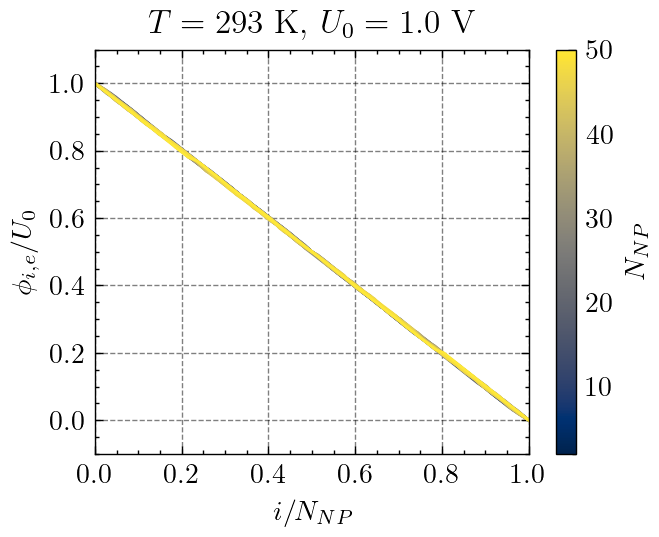

In [5]:
fig     = plt.figure(dpi=200)
ax      = fig.add_subplot()
norm    = Normalize(vmin=min(N_vals), vmax=max(N_vals))

for i, N in enumerate(N_vals):

    p   = pot_eq[N].dropna().values.copy()
    p   = np.insert(p, 0, 1.0)
    p   = np.append(p, 0.0)
    x   = np.linspace(0,1,len(p))
    ax.plot(x, p, color=cm(norm(N)))

ax.set_title(f"$T = 293$ K, $U_0 = {U_0}$ V")
ax.set_ylim(-0.1,1.1)
ax.set_xlim(0,1)
ax.set_ylabel("$\phi_{i,e} / U_0$")
ax.set_xlabel("$i / N_{NP}$")

sm  = ScalarMappable(cmap=cm, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("$N_{NP}$")

fig.savefig("../plots/dc_input/linear/closed_circuit_node_potential.svg", transparent=True)

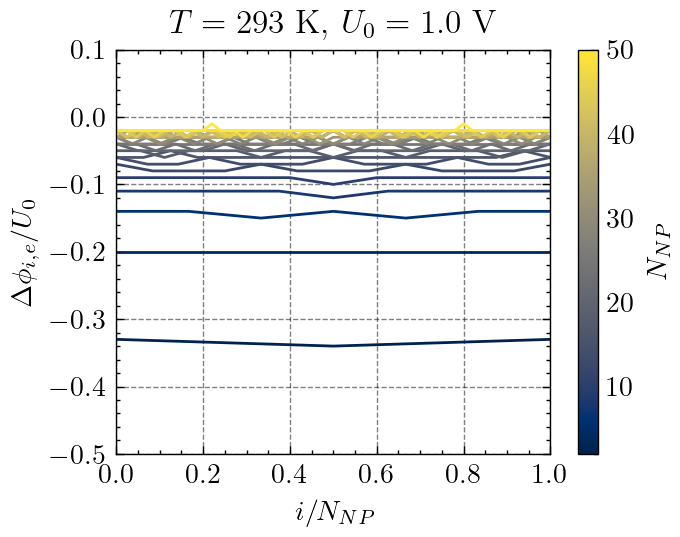

In [6]:
fig     = plt.figure(dpi=200)
ax      = fig.add_subplot()
norm    = Normalize(vmin=min(N_vals), vmax=max(N_vals))

for i, N in enumerate(N_vals):

    arr = pot_eq[N].dropna().values.copy()*U_0
    arr = np.insert(arr, 0, U_0)
    arr = np.append(arr, 0.0)
    arr = np.diff(arr)/U_0
    x   = np.linspace(0,1,len(arr))

    ax.plot(x, arr, color=cm(norm(N)))

ax.set_title(f"$T = 293$ K, $U_0 = {U_0}$ V")
ax.set_xlim(0,1)
ax.set_ylim(-0.5, 0.1)
ax.set_ylabel("$\Delta \phi_{i,e} / U_0$")
ax.set_xlabel("$i / N_{NP}$")

sm  = ScalarMappable(cmap=cm, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("$N_{NP}$")

fig.savefig("../plots/dc_input/linear/closed_circuit_node_potential_difference.svg", transparent=True)

- Potential decays linearly from $U_0$ to $0$ V, which confirms the **Ohmic response** of the string $$\phi_i = U_0 (1 - \frac{i}{N_{NP}})$$
- Equal potential difference $\Delta \phi = \frac{U_0}{N_{NP}}$ imply uniform **voltage drops** across each junction

### Characteristic Time Scale

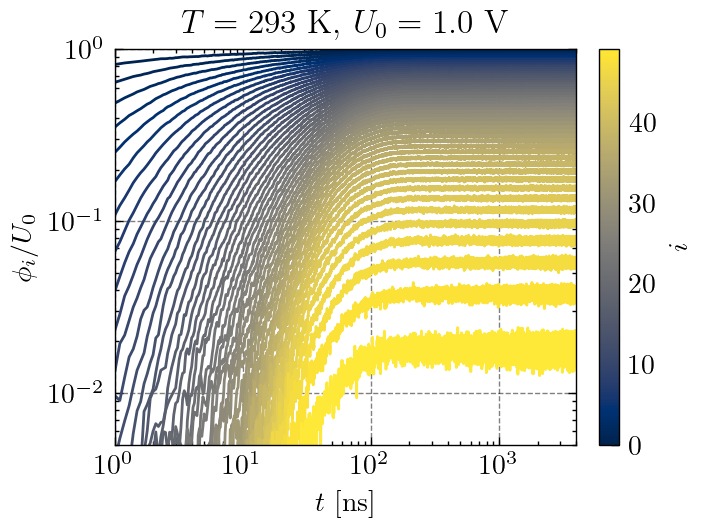

In [7]:
fig     = plt.figure(dpi=200, layout='constrained')
ax      = fig.add_subplot()
norm    = Normalize(vmin=0, vmax=49)
Np      = 50

for i in range(Np):
    ax.plot(t_vals, pot[Np][f"{i}"].values/U_0, color=cm(norm(i)))

ax.set_title(f"$T = 293$ K, $U_0 = {U_0}$ V")
ax.set_xlim(1,4000)
ax.set_ylim(0.005,1)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel("$\phi_i / U_0$")
ax.set_xlabel("$t$ [ns]")

sm  = ScalarMappable(cmap=cm, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("$i$")

fig.savefig("../plots/dc_input/linear/closed_circuit_node_time_series.svg", transparent=True)

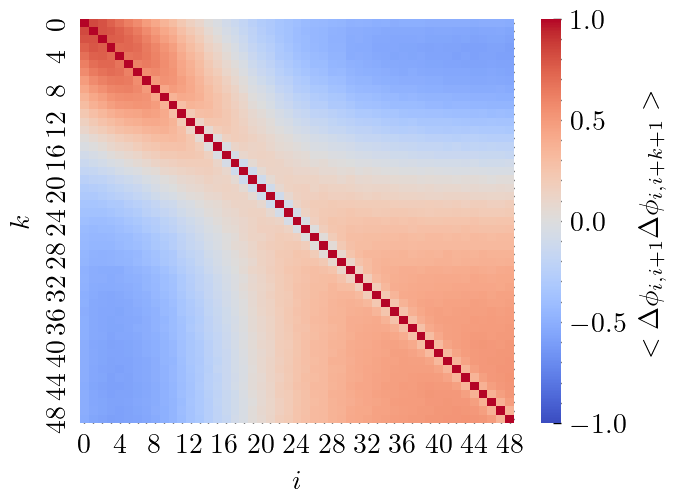

In [21]:
Np      = 50
p_diff  = pot[Np].diff(axis=1).drop(columns="0").values
p_diff  = np.insert(p_diff, 0, np.zeros(Np-1), axis=0)
delta_p = pd.DataFrame(p_diff)

fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
ax  = sns.heatmap(delta_p.corr(), cmap='coolwarm', vmin=-1, vmax=1, ax=ax,
                  cbar_kws={"label":"$<\Delta\phi_{i,i+1}\Delta\phi_{i,i+k+1}>$"})
ax.set_xlabel("$i$")
ax.set_ylabel("$k$")

fig.savefig("../plots/dc_input/linear/closed_circuit_node_pot_diff_corr.svg", transparent=True)

- Strong short range correlations: Diffusive charge spreading
- Long range anti-correlations: Charges at distant NPs adjust to maintain linear potential gradient globally

In [47]:
def characteristic_time(t_vals, pot_df, Np, steady_start=20000, consecutive_points=50, p_th=0.63):

    end_vals    = pot_df[Np].iloc[steady_start:,:].mean().values
    taus        = []
    p_th        = 0.63

    for i in range(Np):
        vals        = pot_df[Np].loc[:,f'{i}'].values
        threshold   = p_th*end_vals[i]
        above_th    = vals > threshold
        for j in range(len(above_th) - consecutive_points):
            if all(above_th[j:j+consecutive_points]):
                tau = t_vals[j]
                taus.append(tau)
                break
    
    return taus

def characteristic_time_saturation(t_vals, pot_df, Np):

    def saturation_cuve(t, tau, a0):
        return a0*(1 - np.exp(-t / tau))

    tau     = []
    params  = []
    for i in range(Np):
        x       = t_vals.copy()
        y       = pot_df[Np].loc[:,f'{i}'].values
        p, _    = curve_fit(saturation_cuve, x, y, bounds=((0,0),(np.inf,np.inf)))
        tau.append(p[0])
        params.append(p)

    return tau, params

def characteristic_time_stretched_saturation(t_vals, pot_df, Np, p0):

    def stretched_saturation_curve(t, tau, a0, beta):
        return a0*(1 - np.exp(-((t/tau)**beta)))

    tau     = []
    params  = []
    for i in range(Np):
        x       = t_vals.copy()
        y       = pot_df[Np].loc[:,f'{i}'].values
        p, _    = curve_fit(stretched_saturation_curve, x, y, p0=p0[i,:], bounds=((0,0,0),(np.inf,np.inf,np.inf)))
        tau_val = gamma(1/p[2])*p[0]/p[2]
        tau.append(tau_val)
        params.append(p)
        # print(p)

    return tau, params

In [26]:
Np                                  = 50
taus, params                        = characteristic_time_saturation(t_vals, pot, Np)
p0_vals                             = np.hstack((np.array(params),np.ones(shape=(50,1))))
taus_stretched, params_stretched    = characteristic_time_stretched_saturation(t_vals, pot, Np, p0_vals)

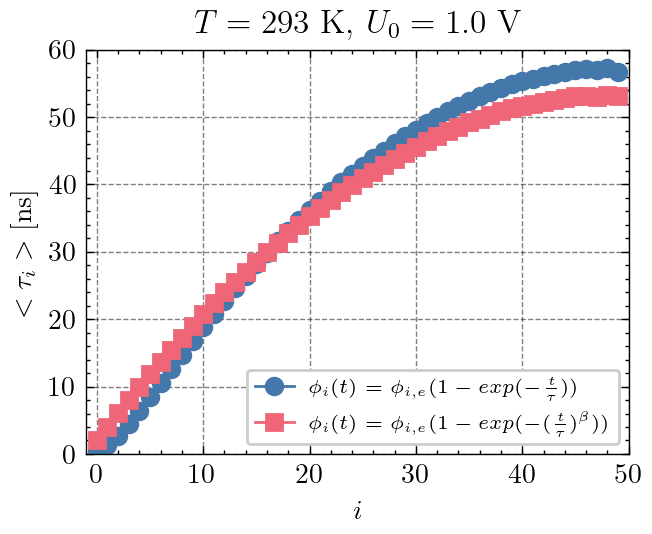

In [29]:
fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
xp  = range(Np)
ax.plot(xp, taus, '-o', label="$\phi_i(t) = \phi_{i,e}(1 - exp(-\\frac{t}{\\tau}))$")
ax.plot(xp, taus_stretched, '-s', label="$\phi_i(t) = \phi_{i,e}(1 - exp(-(\\frac{t}{\\tau})^\\beta))$")
ax.set_xlabel("$i$")
ax.set_ylabel("$<\\tau_i>$ [ns]")
ax.set_ylim(0,60)
ax.set_xlim(-1,50)
ax.legend(fontsize='x-small')
ax.set_title(f"$T = 293$ K, $U_0 = {U_0}$ V")

fig.savefig("../plots/dc_input/linear/closed_circuit_node_time_scales.svg", transparent=True)

In [32]:
tau_s               = []
tau_s_stretched     = []

for Np in N_vals:
    taus, p             = characteristic_time_saturation(t_vals, pot, Np)
    tau_s.append(np.max(taus))
    p0_vals             = np.hstack((np.array(p),np.ones(shape=(Np,1))))
    taus_s_stretched    = characteristic_time_stretched_saturation(t_vals, pot, Np, p0_vals)
    tau_s_stretched.append(taus)

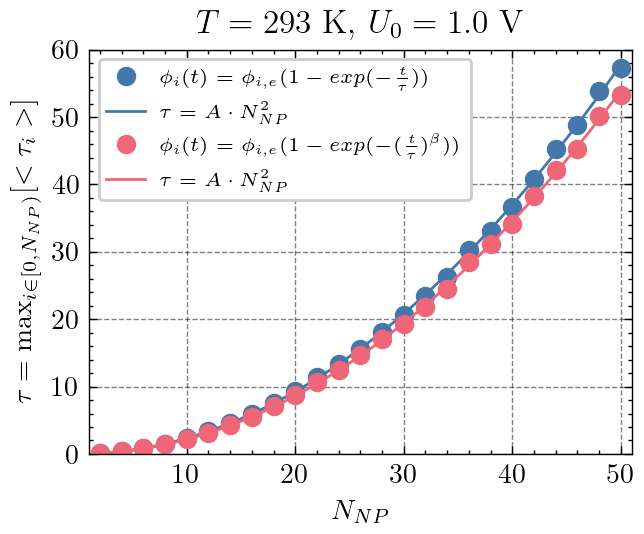

In [34]:
def quad_func(x, a):
    return a*x**2

fig = plt.figure(dpi=200)
ax  = fig.add_subplot()

p,_ = curve_fit(quad_func, N_vals, tau_s)
pp  = ax.plot(N_vals, tau_s, 'o', label="$\phi_i(t) = \phi_{i,e}(1 - exp(-\\frac{t}{\\tau}))$")
ax.plot(N_vals, quad_func(np.array(N_vals), *p), color=pp[0].get_color(), label="$\\tau = A \cdot N_{NP}^2$")

p,_ = curve_fit(quad_func, N_vals, tau_s_stretched)
pp  = ax.plot(N_vals, tau_s_stretched, 'o', label="$\phi_i(t) = \phi_{i,e}(1 - exp(-(\\frac{t}{\\tau})^\\beta))$")
ax.plot(N_vals, quad_func(np.array(N_vals), *p), color=pp[0].get_color(), label="$\\tau = A \cdot N_{NP}^2$")

# ax.plot(N_vals, quad_func(np.array(N_vals), R*(2*Cm+Cs)*1e9 / (np.pi**2)), color='black', label="$\\tau = \\frac{R \cdot (2C_m + C_s)}{\pi^2} \cdot N_{NP}^2$")
# ax.plot(N_vals, tau_i, color='black', label="$\\tau = \\frac{R \cdot (2C_m + C_s)}{\pi^2} \cdot N_{NP}^2$")

# ax.set_ylabel("$\\underset{i \in [0,N_{NP})}{\max} <\\tau_i>$")
ax.set_ylabel("$\\tau = \max_{i \in [0,N_{NP})}[<\\tau_i>]$")
ax.set_ylim(0,60)
ax.set_xlim(1,51)
ax.set_xlabel("$N_{NP}$")
ax.legend(fontsize='x-small')
ax.set_title(f"$T = 293$ K, $U_0 = {U_0}$ V")

fig.savefig("../plots/dc_input/linear/closed_circuit_time_scales_vs_N.svg", transparent=True)

- $N^2$ dependence as we have **diffusive-limited relaxation** (governed by $R$ and $C$)
- We get about the same prefactor as theory suggests. Deviations due to finite-$N$
- We have a ***hierarchical timescale*** of eigenmodes, i.e. first NPs relax faster and last NP are driven by slowest mode

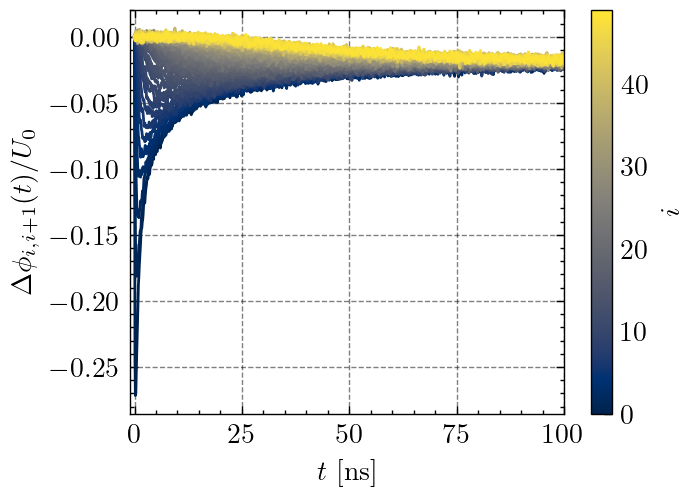

In [35]:
Np      = 50
norm    = Normalize(vmin=0, vmax=(Np-1))
t_f_d   = np.arange(N_voltages)*1e-10*1e9
p_diff  = pot[Np].diff(axis=1).drop(columns="0").values
p_diff  = np.insert(p_diff, 0, np.zeros(Np-1), axis=0)
fig     = plt.figure(dpi=200)
ax      = fig.add_subplot()
for i in range(Np-1):
    ax.plot(t_f_d, p_diff[:,i]/U_0, color=cm(norm(i)), label=f'${i}$')
ax.set_xlim(-1,100)
ax.set_ylabel("$\Delta \phi_{i,i+1}(t) / U_0$")
ax.set_xlabel("$t$ [ns]")

sm  = ScalarMappable(cmap=cm, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("$i$")

# ax.legend(fontsize='x-small', ncol=2)

## DC Input - Voltage Distribution - Open Circuit

In [36]:
# folder      = "/mnt/c/Users/jonas/Desktop/phd/data/2_funding_period/potential/wo_magic_cable/dc_input_vs_size/293/"
folder      = "/home/j/j_mens07/phd/data/2_funding_period/potential/wo_magic_cable/dc_input_vs_size/293/"
N_voltages  = 40000
U_0         = 1.0
t_vals      = np.arange(N_voltages-1)*1e-10*1e9
N_vals      = [2,4,6,8,10,12,14,16,18,20,22,24,26,28,30,32,34,36,38,40,42,44,46,48,50]
pot         = {N_p : pd.read_csv(f"{folder}mean_state_Nx={N_p}_Ny=1_Nz=1_Ne=2.csv") for N_p in N_vals}
pot_eq      = pd.DataFrame([pot[N_p].iloc[38000:,:].mean().values / U_0 for N_p in N_vals],index=N_vals).T.round(2)

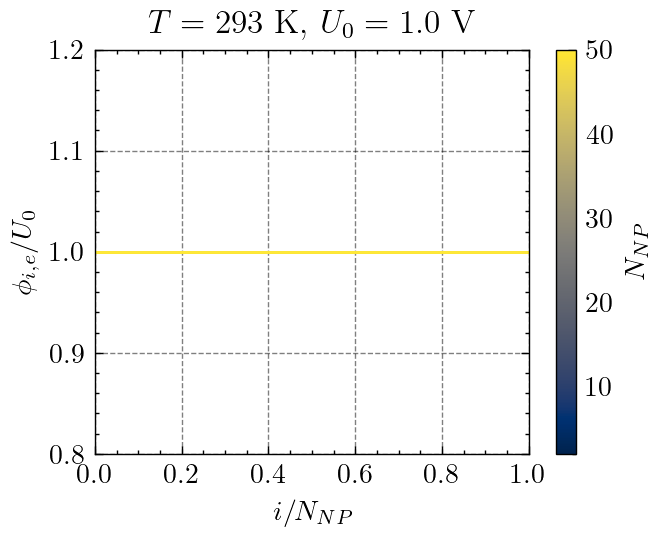

In [37]:
fig     = plt.figure(dpi=200)
ax      = fig.add_subplot()
norm    = Normalize(vmin=min(N_vals), vmax=max(N_vals))

for i, N in enumerate(N_vals):

    p   = pot_eq[N].dropna().values.copy()
    p   = np.insert(p, 0, 1.0)
    x   = np.linspace(0,1,len(p))
    ax.plot(x, p, color=cm(norm(N)))

ax.set_title(f"$T = 293$ K, $U_0 = {U_0}$ V")
ax.set_ylim(0.8,1.2)
ax.set_xlim(0,1)
ax.set_ylabel("$\phi_{i,e} / U_0$")
ax.set_xlabel("$i / N_{NP}$")

sm  = ScalarMappable(cmap=cm, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("$N_{NP}$")

fig.savefig("../plots/dc_input/linear/open_circuit_node_potential.svg", transparent=True)

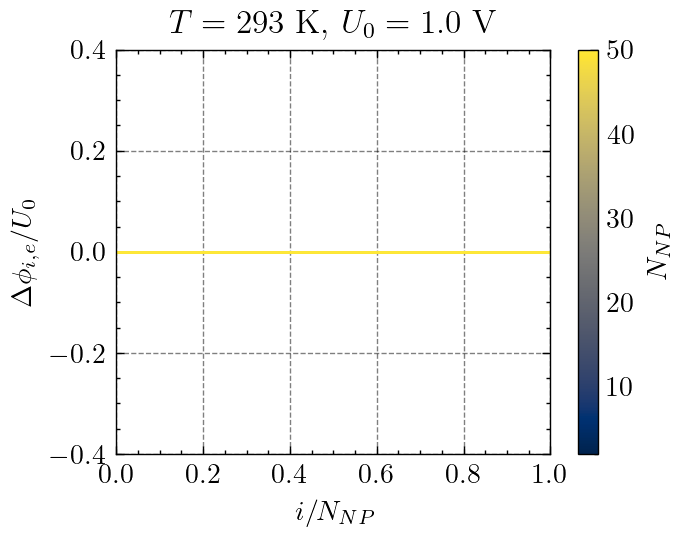

In [38]:
fig     = plt.figure(dpi=200)
ax      = fig.add_subplot()
norm    = Normalize(vmin=min(N_vals), vmax=max(N_vals))

for i, N in enumerate(N_vals):

    arr = pot_eq[N].dropna().values.copy()*U_0
    arr = np.insert(arr, 0, U_0)
    arr = np.diff(arr)/U_0
    x   = np.linspace(0,1,len(arr))

    ax.plot(x, arr, color=cm(norm(N)))

ax.set_title(f"$T = 293$ K, $U_0 = {U_0}$ V")
ax.set_xlim(0,1)
ax.set_ylim(-0.4, 0.4)
ax.set_ylabel("$\Delta \phi_{i,e} / U_0$")
ax.set_xlabel("$i / N_{NP}$")

sm  = ScalarMappable(cmap=cm, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("$N_{NP}$")

fig.savefig("../plots/dc_input/linear/open_circuit_node_potential_difference.svg", transparent=True)

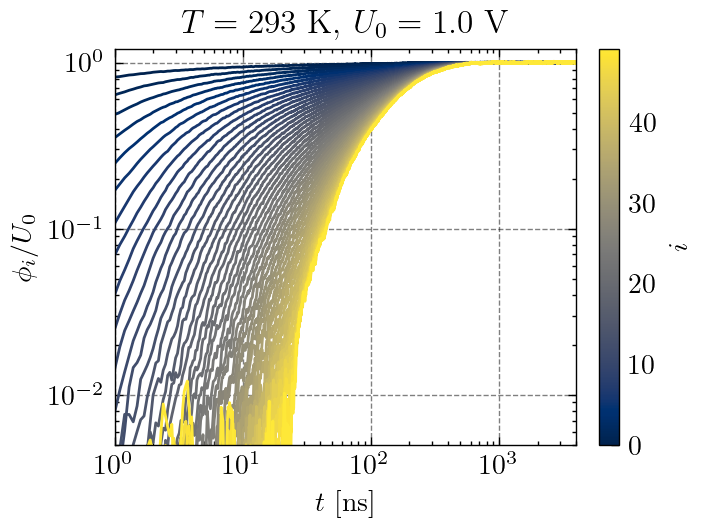

In [39]:
fig     = plt.figure(dpi=200, layout='constrained')
ax      = fig.add_subplot()
norm    = Normalize(vmin=0, vmax=49)
Np      = 50

for i in range(Np):
    ax.plot(t_vals, pot[Np][f"{i}"].values/U_0, color=cm(norm(i)))

ax.set_title(f"$T = 293$ K, $U_0 = {U_0}$ V")
ax.set_xlim(1,4000)
ax.set_ylim(0.005,1.2)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel("$\phi_i / U_0$")
ax.set_xlabel("$t$ [ns]")

sm  = ScalarMappable(cmap=cm, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("$i$")

fig.savefig("../plots/dc_input/linear/open_circuit_node_time_series.svg", transparent=True)

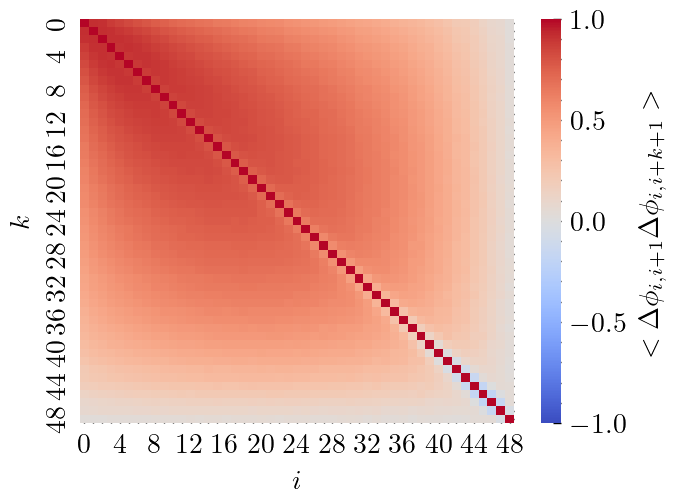

In [41]:
Np      = 50
p_diff  = pot[Np].diff(axis=1).drop(columns="0").values
p_diff  = np.insert(p_diff, 0, np.zeros(Np-1), axis=0)
delta_p = pd.DataFrame(p_diff)

fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
ax  = sns.heatmap(delta_p.corr(), cmap='coolwarm', vmin=-1, vmax=1, ax=ax,
                  cbar_kws={"label":"$<\Delta\phi_{i,i+1}\Delta\phi_{i,i+k+1}>$"})
ax.set_xlabel("$i$")
ax.set_ylabel("$k$")

fig.savefig("../plots/dc_input/linear/open_circuit_node_pot_diff_corr.svg", transparent=True)

- Without a ground path, charges accumulate until the **entire string floats** at $U_0$ --> $\phi_i \approx U_0 \forall i$

In [49]:
Np                                  = 50
taus, params                        = characteristic_time_saturation(t_vals, pot, Np)
p0_vals                             = np.hstack((np.array(params),np.ones(shape=(Np,1))))
taus_stretched, params_stretched    = characteristic_time_stretched_saturation(t_vals, pot, Np, p0_vals)

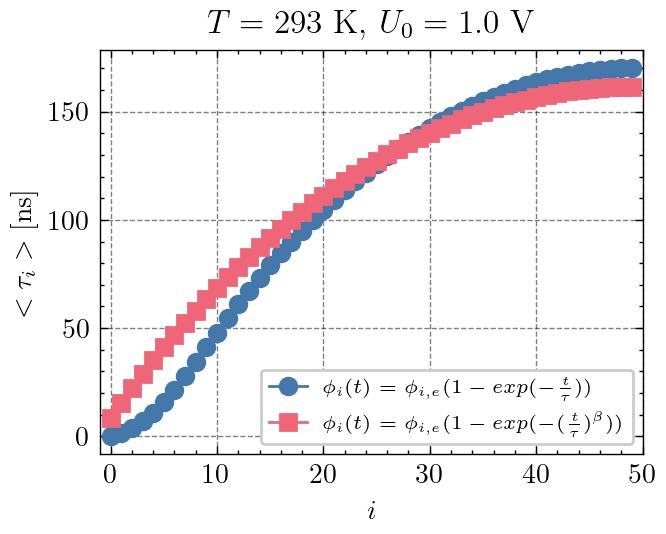

In [50]:
fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
xp  = range(Np)
ax.plot(xp, taus, '-o', label="$\phi_i(t) = \phi_{i,e}(1 - exp(-\\frac{t}{\\tau}))$")
ax.plot(xp, taus_stretched, '-s', label="$\phi_i(t) = \phi_{i,e}(1 - exp(-(\\frac{t}{\\tau})^\\beta))$")
ax.set_xlabel("$i$")
ax.set_ylabel("$<\\tau_i>$ [ns]")
# ax.set_ylim(0,60)
ax.set_xlim(-1,50)
ax.legend(fontsize='x-small')
ax.set_title(f"$T = 293$ K, $U_0 = {U_0}$ V")

fig.savefig("../plots/dc_input/linear/open_circuit_node_time_scales.svg", transparent=True)

In [53]:
taus_s_stretched

([np.float64(0.21393630447377476), np.float64(0.315574024509607)],
 [array([0.13989708, 1.00002059, 0.59264785]),
  array([0.27816703, 1.00001   , 0.7985513 ])])

In [54]:
tau_s               = []
tau_s_stretched     = []

for Np in N_vals:
    taus, p             = characteristic_time_saturation(t_vals, pot, Np)
    tau_s.append(np.max(taus))
    p0_vals             = np.hstack((np.array(p),np.ones(shape=(Np,1))))
    taus_s_stretched, p = characteristic_time_stretched_saturation(t_vals, pot, Np, p0_vals)
    tau_s_stretched.append(np.max(taus_s_stretched))

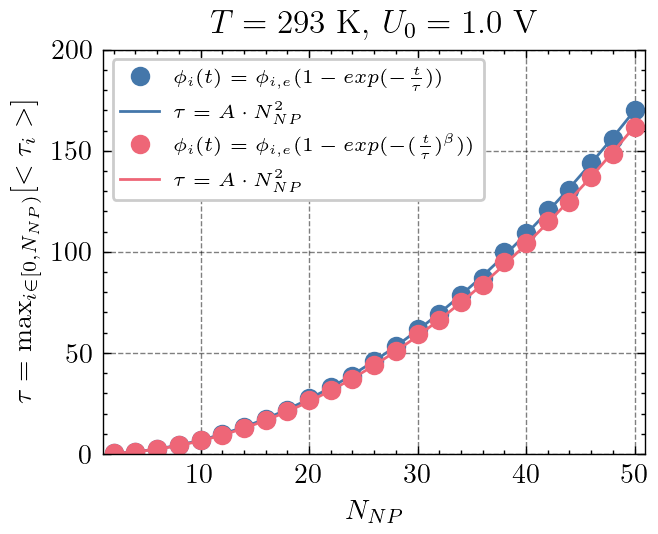

In [56]:
def quad_func(x, a):
    return a*x**2

fig = plt.figure(dpi=200)
ax  = fig.add_subplot()

p,_ = curve_fit(quad_func, N_vals, tau_s)
pp  = ax.plot(N_vals, tau_s, 'o', label="$\phi_i(t) = \phi_{i,e}(1 - exp(-\\frac{t}{\\tau}))$")
ax.plot(N_vals, quad_func(np.array(N_vals), *p), color=pp[0].get_color(), label="$\\tau = A \cdot N_{NP}^2$")

p,_ = curve_fit(quad_func, N_vals, tau_s_stretched)
pp  = ax.plot(N_vals, tau_s_stretched, 'o', label="$\phi_i(t) = \phi_{i,e}(1 - exp(-(\\frac{t}{\\tau})^\\beta))$")
ax.plot(N_vals, quad_func(np.array(N_vals), *p), color=pp[0].get_color(), label="$\\tau = A \cdot N_{NP}^2$")

# ax.plot(N_vals, quad_func(np.array(N_vals), R*Cm*1e9), color='black', label="$\\tau = RC \cdot N_{NP}^2$")

# ax.set_ylabel("$\\underset{i \in [0,N_{NP})}{\max} <\\tau_i>$")
ax.set_ylabel("$\\tau = \max_{i \in [0,N_{NP})}[<\\tau_i>]$")
ax.set_ylim(0,200)
ax.set_xlim(1,51)
ax.set_xlabel("$N_{NP}$")
ax.legend(fontsize='x-small')
ax.set_title(f"$T = 293$ K, $U_0 = {U_0}$ V")

fig.savefig("../plots/dc_input/linear/open_circuit_time_scales_vs_N.svg", transparent=True)

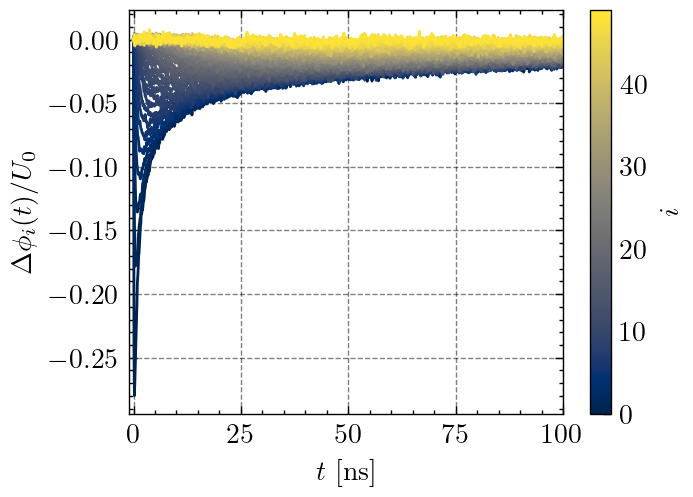

In [57]:
Np      = 50
norm    = Normalize(vmin=0, vmax=(Np-1))
t_f_d   = np.arange(N_voltages)*1e-10*1e9
p_diff  = pot[Np].diff(axis=1).drop(columns="0").values
p_diff  = np.insert(p_diff, 0, np.zeros(Np-1), axis=0)
fig     = plt.figure(dpi=200)
ax      = fig.add_subplot()
for i in range(Np-1):
    ax.plot(t_f_d, p_diff[:,i]/U_0, color=cm(norm(i)), label=f'${i}$')
ax.set_xlim(-1,100)
ax.set_ylabel("$\Delta \phi_i(t) / U_0$")
ax.set_xlabel("$t$ [ns]")

sm  = ScalarMappable(cmap=cm, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("$i$")

# ax.legend(fontsize='x-small', ncol=2)

---